# 车辆检测
## 主要的步骤如下：
- 定义图像特征提取方法
- 读入车辆和非车辆图像数据
- 数据预处理，shuffle，标准化
- 训练模型
- 测试模型
- 使用滑动窗口和多尺度的图像大小在图像上检测车辆
- 检测视频中行驶的车辆

> 问题：现在特征提取的速度特别慢。使用CNN对物体进行识别会提高不少效率。

## 1.汽车和非汽车图片展示

汽车样本数量： 8792
非汽车样本数量： 8968


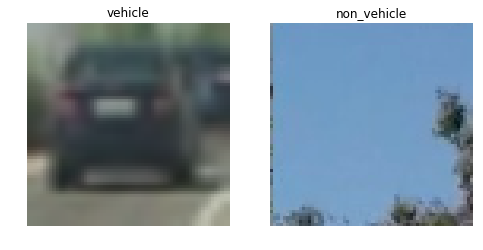

In [2]:
import glob
import matplotlib.pyplot as plt

vehicle_lable = 1
non_vehicle_label = 0

# 读入数据
vehicles_file_paths = glob.glob("./vehicles/*/*.png")
non_vehicles_file_paths = glob.glob("./non-vehicles/*/*.png")
print("汽车样本数量：" , len(vehicles_file_paths))
print("非汽车样本数量：" , len(non_vehicles_file_paths))

# 显示汽车和非汽车图片
vehicle_img = plt.imread(vehicles_file_paths[0])
non_vehicle_img = plt.imread(non_vehicles_file_paths[0])
fig, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(8, 20))
ax1.imshow(vehicle_img)
ax1.set_title("vehicle")
ax1.axis('off')
ax2.imshow(non_vehicle_img)
ax2.set_title("non_vehicle")
ax2.axis('off')
plt.show()

### 2.下面的代码定义了一些图像特征提取的方法，包括HOG特征，空间特征，颜色直方图，最后把这些特征合并成一个特征

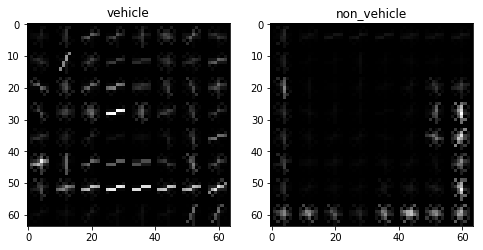

In [3]:
import numpy as np
import cv2
import matplotlib.image as mpimg
from skimage.feature import hog

def convert_color(img, conv):
    """
    颜色空间转换
    """
    return cv2.cvtColor(img, conv)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """
    提取图像的hog特征
    """
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# 测试提取HOG特征
vehicle_img = mpimg.imread(vehicles_file_paths[0])
non_vehicle_img = mpimg.imread(non_vehicles_file_paths[0])
v_hog_feats,v_hog_imgs = get_hog_features(vehicle_img[:, :, 0], 9, 8, 2, vis=True, feature_vec=False)
n_hog_feats,n_hog_imgs = get_hog_features(non_vehicle_img[:, :, 0], 9, 8, 2, vis=True, feature_vec=False)

# 显示汽车和非汽车图片
vehicle_img = mpimg.imread(vehicles_file_paths[0])
non_vehicle_img = mpimg.imread(non_vehicles_file_paths[0])
fig, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(8, 20))
ax1.imshow(v_hog_imgs, cmap="gray")
ax1.set_title("vehicle")
ax2.imshow(n_hog_imgs, cmap="gray")
ax2.set_title("non_vehicle")
plt.show()

In [4]:
def bin_spatial(img, size=(32, 32)):
    """
    提取图像的空间特征
    """
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):
    """
    颜色直方图
    """
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def extract_img_features(img):
    """
    把之上的图像处理方法进行综合，且对结果进行归一化处理
    """
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    hist_feature = color_hist(img)
    spatial_feature = bin_spatial(img)
    ch1 = img[:, :, 0]
    ch2 = img[:, :, 1]
    ch3 = img[:, :, 2]
    ch1_hog_feature = get_hog_features(ch1, 9, 8, 2)
    ch2_hog_feature = get_hog_features(ch2, 9, 8, 2)
    ch3_hog_feature = get_hog_features(ch3, 9, 8, 2)
    hog_features = np.hstack((ch1_hog_feature, ch2_hog_feature, ch3_hog_feature))
    features = np.concatenate((hist_feature, spatial_feature, hog_features))
    return features

### 3. 提取图像特征作为训练数据

In [5]:
X = []
y = []
for path in vehicles_file_paths:
    img = mpimg.imread(path)
    features = extract_img_features(img)
    X.append(features)
    y.append(vehicle_lable)

for path in non_vehicles_file_paths:
    img = mpimg.imread(path)
    features = extract_img_features(img)
    X.append(features)
    y.append(non_vehicle_label)

### 4.数据预处理 shuffle —> 分割训练集和测试集 —>标准化
> 注意：数据标准化的时候，使用训练数据作为fit的对象。

In [6]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# shuffle
X, y = shuffle(X, y)
# split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
# scaller
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

### 4.训练模型

In [7]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

### 5.模型测试

In [8]:
from sklearn.metrics import accuracy_score

predicts = svm.predict(X_test)
score = accuracy_score(predicts, y_test)
print("在测试数据上的准确率为：", score)

在测试数据上的准确率为： 0.984515765766


### 6.使用滑动窗口查找图像上的汽车

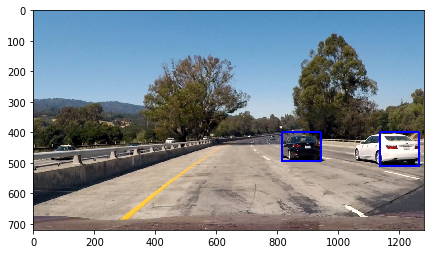

In [9]:
from scipy.ndimage.measurements import label


def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    """
    检测当前图像中的所有可能的汽车位置
    """
    
    boxs = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hist_features, spatial_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxs.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
    return boxs

img = mpimg.imread("test_images/test1.jpg")
boxs = find_cars(img, 400, 600, 1, svm, X_scaler, 9, 8, 2, (32, 32), 32)
# 创建热度图
heatmap = np.zeros_like(img[:, :, :]).astype(np.float)
for box in boxs:
    heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0], 0] += 1
    
heatmap[heatmap < 3] = 0
labels = label(heatmap)
for car_number in range(1, labels[1] + 1):
    nonzero = (labels[0] == car_number).nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
    cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    
    
fig,ax1 = plt.subplots(1, 1, figsize=(7, 12))
ax1.imshow(img)
plt.show()

In [10]:
box_center = []
def detect_object(img):
    """
    物体检测，缩放窗口的大小，对检测到的图像的两
    """
    
    bbox_list = []
    # 分别对各个尺度的窗口查找汽车的位置
    boxs = find_cars(img, 400, 656, 1.2, svm, X_scaler, 9, 8, 2, (32, 32), 32)
    bbox_list = bbox_list + boxs
    boxs = find_cars(img, 400, 600, 1, svm, X_scaler, 9, 8, 2, (32, 32), 32)
    bbox_list = bbox_list + boxs
    boxs = find_cars(img, 400, 500, 0.8, svm, X_scaler, 9, 8, 2, (32, 32), 32)
    bbox_list = bbox_list + boxs
    # 创建热度图
    heatmap = np.zeros_like(img[:, :, 0]).astype(np.float)
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # 排除掉出现频率小的汽车检测位置
    heatmap[heatmap <=8] = 0
    # 对汽车的位置进行标记，画矩形
    labels = label(heatmap)
    for car_number in range(1, labels[1] + 1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        if len(box_center) > 0:
            for center in box_center:
                if bbox[0][0]  < center[0] < bbox[1][0]  and bbox[0][1] < center[1] < bbox[1][1]:
                    cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
                    break
        box_center.append(((bbox[0][0]+bbox[1][0] )/2, (bbox[0][1] + bbox[1][1])/2))
    return img

### 7.检测视频中的车辆

In [11]:
NeedDownloadError_exists = False
try:
    from moviepy.editor import VideoFileClip
except NeedDownloadError:
    NeedDownloadError_exists = True

if NeedDownloadError_exists:
    import imageio
    imageio.plugins.ffmpeg.download()
    from moviepy.editor import VideoFileClip

from moviepy.editor import VideoFileClip
from IPython.display import HTML

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(detect_object)
#white_clip.write_images_sequence("test_challenge/frame%2d.jpg")
white_clip.write_videofile("project_video_output.mp4", audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_video_output.mp4"))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:47:32<00:05,  5.52s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

